#### Imports

In [23]:
import yfinance as yf  # Download historical financial data from Yahoo Finance
import pandas as pd     # Data manipulation and analysis (DataFrames, time series)
import numpy as np      # Numerical operations and array handling
import matplotlib.pyplot as plt  # Basic plotting and visualizations
import seaborn as sns   # Statistical data visualization (enhanced plots)
from scipy.stats import kurtosis  # Compute kurtosis to detect fat tails
from statsmodels.graphics.tsaplots import plot_acf  # Plot autocorrelation functions
from arch.__future__ import reindexing  # Compatibility fix for arch with newer pandas
from arch import arch_model  # Estimate GARCH and EGARCH models
from statsmodels.stats.diagnostic import acorr_ljungbox  # Perform Ljung-Box test for autocorrelation

#### Downloading Historical Financial Data

In [24]:
assets = {
    'Equity_Index': "^GSPC", # S&P 500       
    'Stock': "AAPL", # Apple              
    'Currency_Pair': "GBPUSD=X", # GBPUSD   
    'Commodity': "ZC=F", # Corn futures       
    'Crypto': "ETH-USD"  # Ethereum          
}

start_date = "2020-05-01"
end_date = "2025-05-01"

data = yf.download(list(assets.values()), start=start_date, end=end_date)["Close"]

[*********************100%***********************]  5 of 5 completed


Renaming the DataFrame columns from technical ticker symbols to more readable asset names and saving the cleaned DataFrame to a CSV file

In [25]:
data = data.rename(columns={'^GSPC':'S&P 500',
                     'AAPL':'Apple',
                     'GBPUSD=X':'GBPUSD',
                     'ZC=F':'Corn futures',
                     "ETH-USD": 'Ethereum'})

data = data.round({col: 2 for col in data.columns if col != 'GBPUSD'})

data.dropna(inplace=True)

data.to_csv('data.csv')


In [26]:
data.head()

Ticker,Apple,Ethereum,GBPUSD,Corn futures,S&P 500
Date,,,,,
2020-05-01,70.06,214.22,1.258147,311.50,2830.71
2020-05-04,71.05,208.17,1.245423,310.75,2842.74
2020-05-05,72.12,206.77,1.244555,313.00,2868.44
2020-05-06,72.86,204.06,1.244420,311.75,2848.42
2020-05-07,73.61,212.29,1.232559,316.00,2881.19


In [27]:
data.tail()

Ticker,Apple,Ethereum,GBPUSD,Corn futures,S&P 500
Date,,,,,
2025-04-24,208.10,1769.83,1.326453,477.25,5484.77
2025-04-25,209.01,1786.63,1.332623,478.75,5525.21
2025-04-28,209.86,1798.85,1.329010,475.50,5528.75
2025-04-29,210.93,1799.18,1.343616,460.50,5560.83
2025-04-30,212.22,1793.78,1.341079,467.25,5569.06


Verify that the DataFrame index is correctly parsed as datetime values

In [28]:
data.index

DatetimeIndex(['2020-05-01', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14',
               ...
               '2025-04-15', '2025-04-16', '2025-04-17', '2025-04-22',
               '2025-04-23', '2025-04-24', '2025-04-25', '2025-04-28',
               '2025-04-29', '2025-04-30'],
              dtype='datetime64[ns]', name='Date', length=1255, freq=None)

The in-sample period is starting on 2020-05-01

In [29]:
in_sample = data.iloc[:-365]

The out-of-sample period is lasting for 365 days and is starting on 2024-05-01

In [30]:
out_of_sample = data.iloc[-365:]

#### Calculating Log Returns

To begin the analysis, we compute the daily logarithmic returns for each instrument in the portfolio. Log returns are preferred over simple returns in financial modeling due to their time-additive property and better statistical characteristics.

The calculation is performed using the natural logarithm of the ratio between consecutive prices. Missing values resulting from shifting are dropped:

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Below are the first few rows of the computed log returns:


In [31]:
log_returns = np.log(data / data.shift(1)).dropna()
log_returns.head()


Ticker,Apple,Ethereum,GBPUSD,Corn futures,S&P 500
Date,,,,,
2020-05-04,0.014032,-0.028648,-0.010164,-0.002411,0.004241
2020-05-05,0.014948,-0.006748,-0.000697,0.007214,0.009000
2020-05-06,0.010208,-0.013193,-0.000108,-0.004002,-0.007004
2020-05-07,0.010241,0.039539,-0.009577,0.013541,0.011439
2020-05-08,0.023628,0.003292,0.004076,0.009449,0.016731


#### Visualization of Log Returns

The following plots display the daily log returns for each of the five assets in the portfolio. This visual inspection allows us to observe volatility clustering a common stylized fact in financial time series and to identify any unusual behavior or structural breaks in the return dynamics over time.

Each subplot corresponds to one asset, with time on the x-axis and log returns on the y-axis. Grid lines and labels are added for better readability.


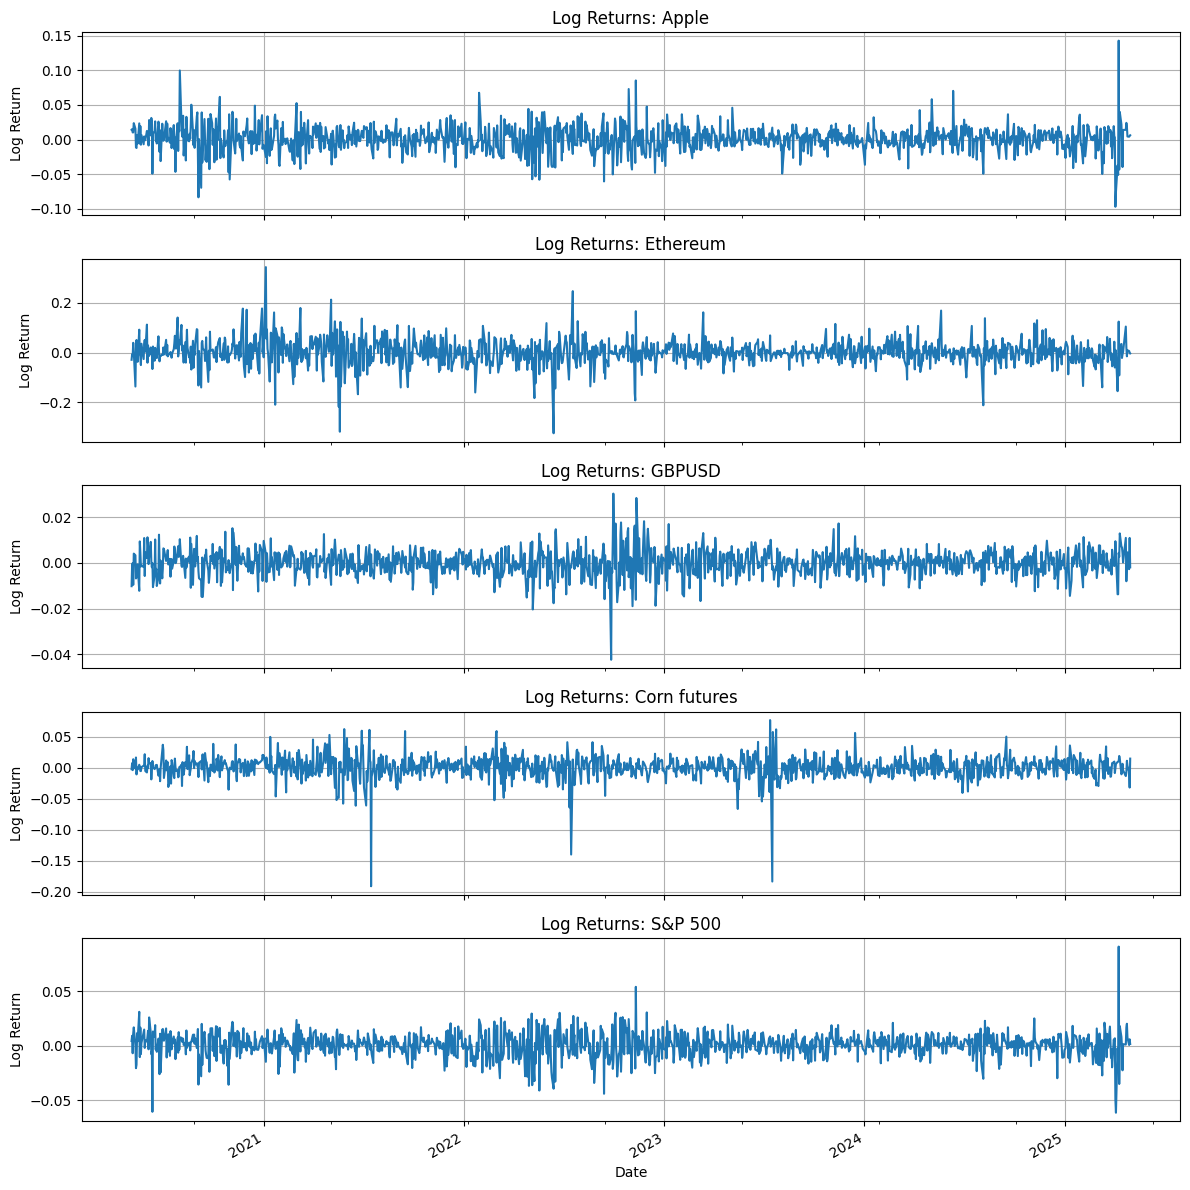

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 12), sharex=True)

for i, asset in enumerate(log_returns.columns):
    ax = axes[i]
    log_returns[asset].plot(ax=ax)
    ax.set_title(f"Log Returns: {asset}")
    ax.set_ylabel("Log Return")
    ax.grid(True)

axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()


#### Volatility of Log Returns

The bar chart below presents the volatility of log returns for each asset in the portfolio, measured as the standard deviation (in percentage terms). 

This metric provides a basic quantitative insight into the relative riskiness of the instruments. Higher values indicate greater variability in returns, which may signal higher potential risk or reward.


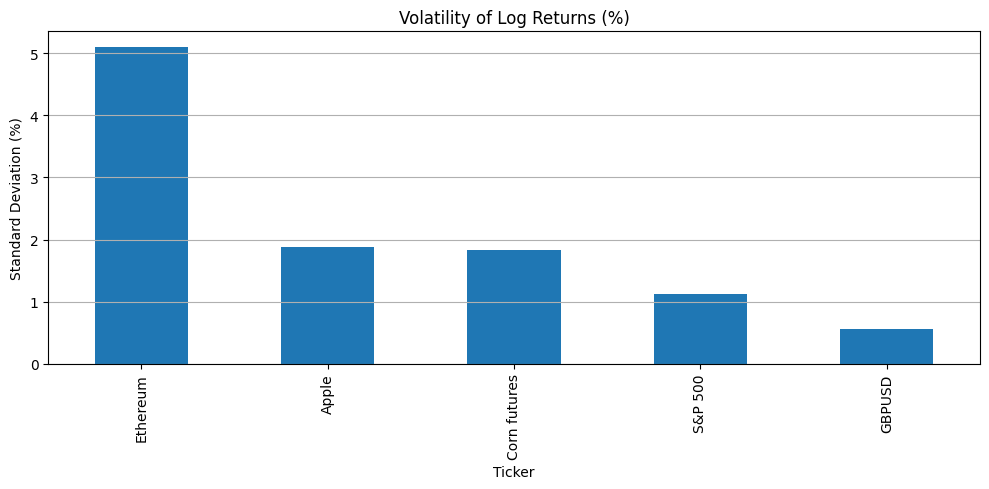

In [33]:
volatility = log_returns.std() * 100  # w %
volatility.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title='Volatility of Log Returns (%)')
plt.ylabel("Standard Deviation (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### Portfolio Log Returns (Equally Weighted)

To analyze the overall portfolio behavior, we compute the log returns of an equally weighted portfolio. Each of the five instruments contributes 20% to the portfolio, and the log returns are combined through matrix multiplication.

The plot below illustrates the daily log returns of the equally weighted portfolio over time. This allows us to assess the aggregated volatility and return behavior of the portfolio as a whole.


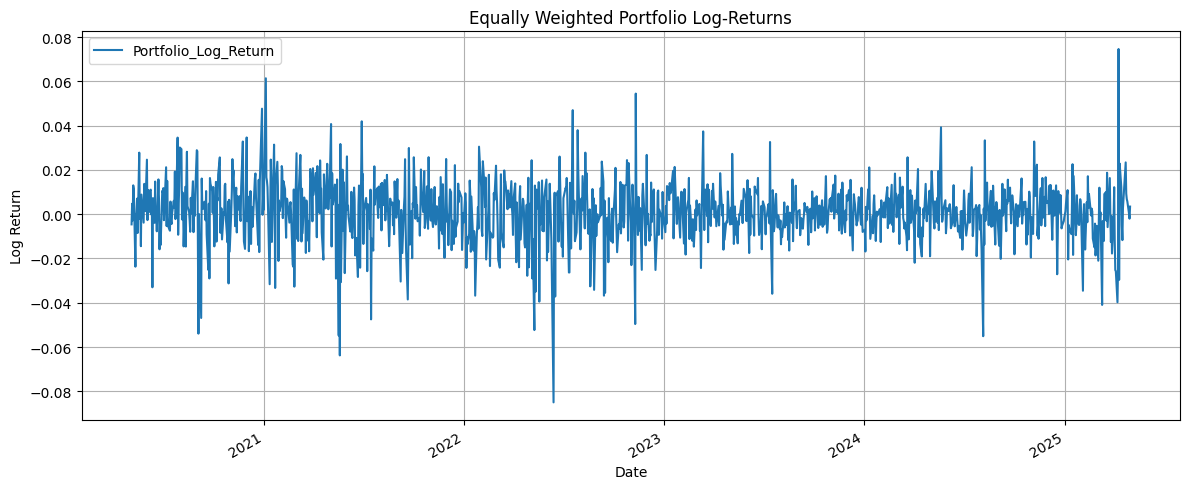

In [ ]:
# Portfolio log-returns (equal weights = 0.2 each)
equal_weights = np.repeat(0.2, 5)
portfolio_returns = log_returns @ equal_weights  # matrix multiplication

portfolio_returns = portfolio_returns.to_frame(name='Portfolio_Log_Return')

# Plotted portfolio log-returns
portfolio_returns.plot(figsize=(12, 5), title='Equally Weighted Portfolio Log-Returns')
plt.ylabel('Log Return')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Distribution of Portfolio Log Returns

The histogram below displays the distribution of the portfolio's daily log returns, overlaid with a Kernel Density Estimate (KDE) to visualize the shape of the distribution.

This visualization helps assess the presence of **leptokurtosis**, a stylized fact often observed in financial return series, indicating heavy tails and a higher peak compared to the normal distribution.

Additionally, we calculate the **sample excess kurtosis** to quantitatively confirm the presence of heavy tails. A value significantly greater than zero suggests leptokurtic behavior.


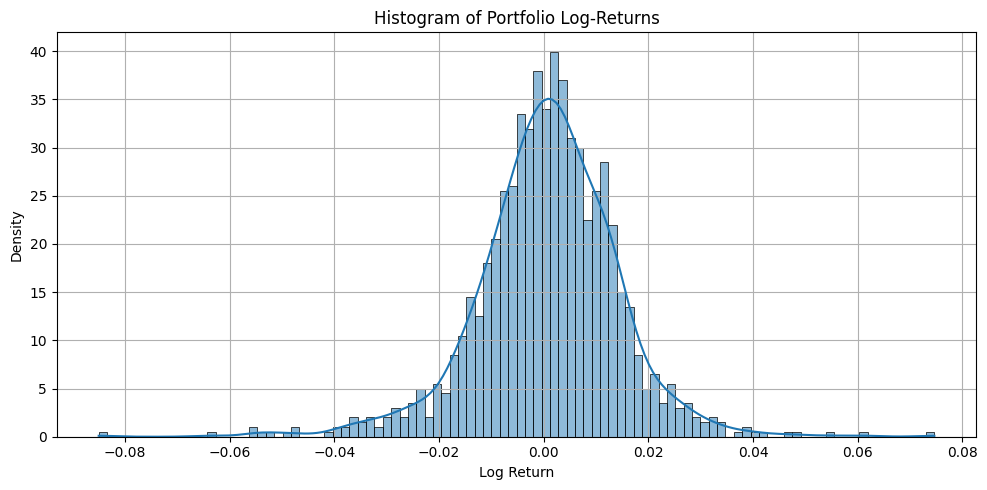

Sample excess kurtosis: 3.71


In [ ]:
# Ploted histogram with KDE
plt.figure(figsize=(10, 5))
sns.histplot(portfolio_returns['Portfolio_Log_Return'], bins=100, kde=True, stat='density')
plt.title('Histogram of Portfolio Log-Returns')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

# Sample kurtosis
kurt = kurtosis(portfolio_returns['Portfolio_Log_Return'], fisher=True)
print(f"Sample excess kurtosis: {kurt:.2f}")


The sample excess kurtosis value of 3.71 is significantly higher than zero (which is the excess kurtosis of a normal distribution), indicating a leptokurtic distribution

### Autocorrelation of Squared Returns

The plot below shows the Autocorrelation Function (ACF) of the squared portfolio log returns. This is a standard diagnostic used to detect **volatility clustering**, one of the key stylized facts in financial time series.

Significant autocorrelation in squared returns suggests that large (or small) movements in returns tend to cluster together, periods of high volatility are followed by high volatility, and low by low.


<Figure size 1000x400 with 0 Axes>

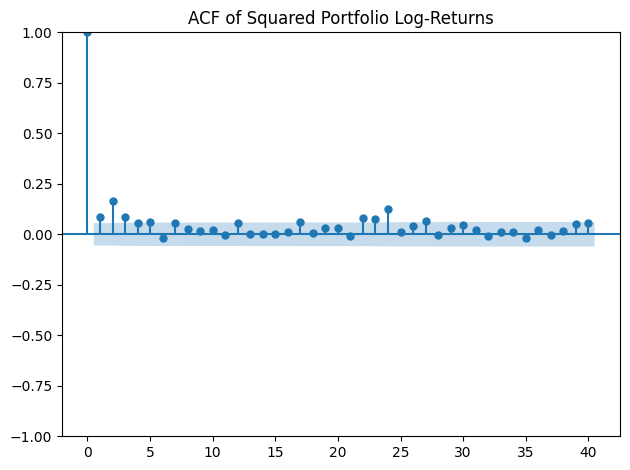

In [ ]:
# Plotted ACF of squared returns
squared_returns = portfolio_returns['Portfolio_Log_Return'] ** 2

plt.figure(figsize=(10, 4))
plot_acf(squared_returns, lags=40, title="ACF of Squared Portfolio Log-Returns")
plt.tight_layout()
plt.show()


The ACF of squared returns shows significant autocorrelation at the first few lags.
This indicates time-varying volatility, supporting the use of GARCH-family models

#### Summary of stylized Facts

1.Volatility clustering – from time series plot

2.Leptokurtosis – from histogram + kurtosis = 3.71

3.ARCH effects – from ACF of squared returns

#### Estimation of EGARCH(1,1) Model

In this step, we estimate an **EGARCH(1,1)** model for the in-sample period (from 2020-05-01 to 2024-04-30) using the portfolio log returns (scaled by 100 for interpretability).

EGARCH (Exponential GARCH) allows for asymmetric effects, meaning it can capture the phenomenon where negative shocks have a different impact on volatility than positive ones (the so-called **leverage effect**).

The model specification includes:
- `p = 1`: GARCH term,
- `q = 1`: ARCH term,
- `o = 1`: asymmetric term,
- `mean = 'Constant'`: constant mean return,
- `dist = 'normal'`: normal distribution of residuals.

The resulting summary provides parameter estimates and diagnostics for model adequacy.


In [ ]:
portfolio_in_sample = portfolio_returns.loc[portfolio_returns.index < "2024-05-01"]

# Fit EGARCH(1,1)
model_egarch_asym = arch_model(portfolio_in_sample * 100, vol='EGARCH', p=1, o=1, q=1, mean='Constant', dist='normal')
result_egarch_asym = model_egarch_asym.fit(disp='off')

print(result_egarch_asym.summary())

                      Constant Mean - EGARCH Model Results                      
Dep. Variable:     Portfolio_Log_Return   R-squared:                       0.000
Mean Model:               Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       EGARCH   Log-Likelihood:               -1699.63
Distribution:                    Normal   AIC:                           3409.27
Method:              Maximum Likelihood   BIC:                           3433.83
                                          No. Observations:                 1005
Date:                  Fri, May 30 2025   Df Residuals:                     1004
Time:                          13:27:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0825  3.828e-02      2.154  3

#### Standardized Residuals and Conditional Volatility

After estimating the EGARCH(1,1) model, we extract the **standardized residuals** and the **conditional volatility**.

- **Standardized residuals** are obtained by dividing raw residuals by the model's estimated conditional standard deviation and are used in diagnostic tests.
- **Conditional volatility** represents the model's estimate of time-varying standard deviation, capturing the changing intensity of return fluctuations over time.


In [ ]:
# Standardized residuals and conditional volatility
std_resid = result_egarch_asym.std_resid
cond_vol = result_egarch_asym.conditional_volatility


#### Plots of Standardized Residuals and Conditional Volatility

The first plot shows the **standardized residuals** from the EGARCH(1,1) model. Ideally, these should resemble white noise — i.e., they should have no significant autocorrelation or patterns over time.

The second plot displays the **conditional volatility**, which reflects the model's estimation of time-varying risk. We observe clear volatility clustering: periods of high volatility tend to follow each other, confirming one of the key stylized facts in financial time series.


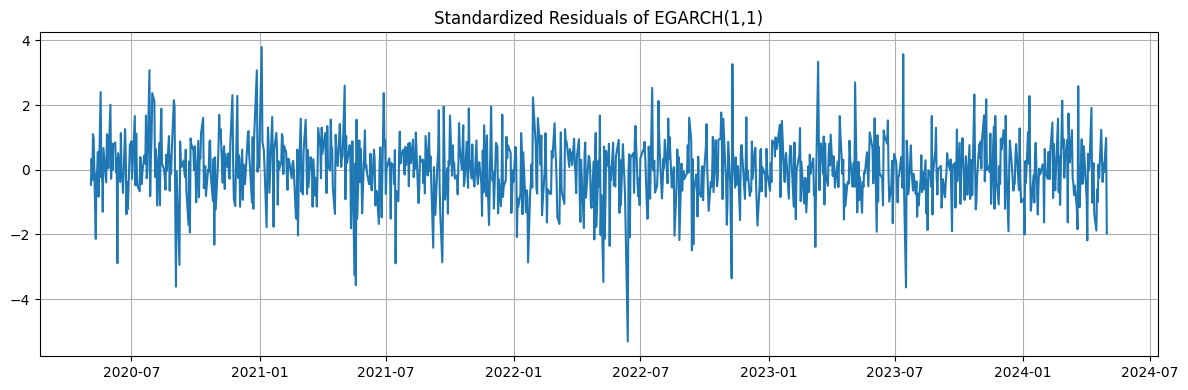

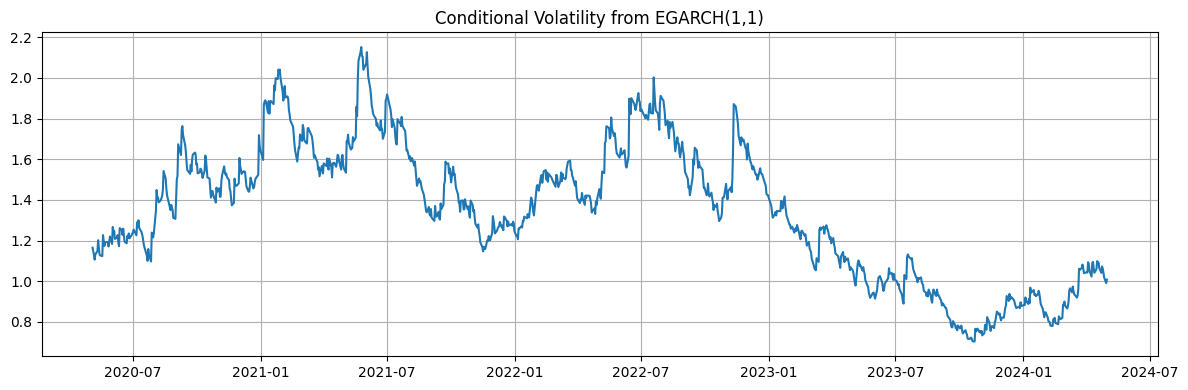

In [ ]:
# Standardized residuals
plt.figure(figsize=(12, 4))
plt.plot(std_resid)
plt.title("Standardized Residuals of EGARCH(1,1)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Conditional volatility
plt.figure(figsize=(12, 4))
plt.plot(cond_vol)
plt.title("Conditional Volatility from EGARCH(1,1)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Standardized Residuals and Conditional Volatility

The first plot shows the **standardized residuals** from the EGARCH(1,1) model. These residuals should ideally behave like white noise and that is, have a mean of zero and no significant autocorrelation. Visual inspection confirms that the residuals fluctuate randomly around zero, with occasional large deviations.

The second plot (not shown here) presents the **conditional volatility** estimated by the model. It highlights periods of increased risk (volatility clustering), which the EGARCH model captures dynamically over time.


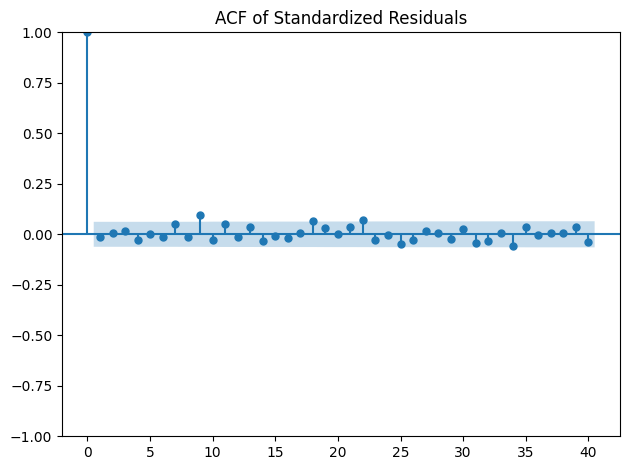

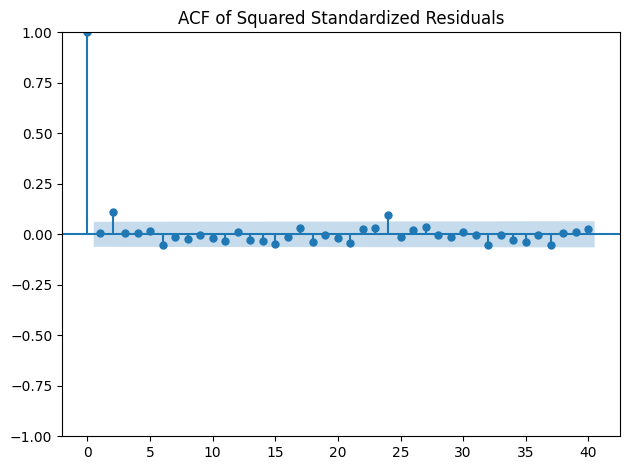

In [ ]:
# ACF of standardized residuals
plot_acf(std_resid, lags=40)
plt.title("ACF of Standardized Residuals")
plt.tight_layout()
plt.show()

# ACF of squared standardized residuals
plot_acf(std_resid**2, lags=40)
plt.title("ACF of Squared Standardized Residuals")
plt.tight_layout()
plt.show()


In [ ]:
# ARCH LM test is built into the result object
arch_lm = result_egarch_asym.arch_lm_test(lags=10)

print("ARCH LM test (10 lags):")
print(arch_lm)


ARCH LM test (10 lags):
ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 39.3910
P-value: 0.0000
Distributed: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000027ED8E6BD90>


Residual diagnostics confirm no significant autocorrelation in standardized and squared residuals. However, the ARCH LM test suggests some residual heteroskedasticity may remain, indicating potential room for model improvement (e.g. heavier-tailed distributions or higher-order terms).

In [ ]:
# Ljung-Box on residuals and squared residuals
ljung_resid = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)
ljung_sq = acorr_ljungbox(std_resid**2, lags=[10, 20], return_df=True)

print("Ljung-Box (standardized residuals):")
print(ljung_resid, "\n")

print("Ljung-Box (squared standardized residuals):")
print(ljung_sq, "\n")


Ljung-Box (standardized residuals):
      lb_stat  lb_pvalue
10  14.365149   0.156978
20  26.080141   0.163181 

Ljung-Box (squared standardized residuals):
      lb_stat  lb_pvalue
10  16.815432   0.078549
20  25.256722   0.191785 



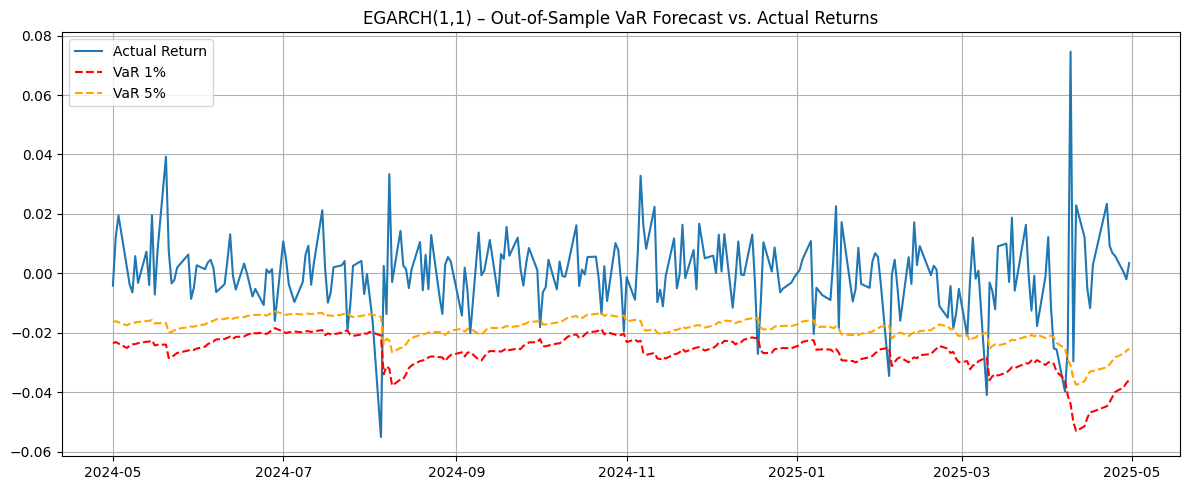

In [ ]:
# Step 1: Setup
returns = portfolio_returns['Portfolio_Log_Return'] * 100  # scale
rolling_window = 1005
returns_oos = returns.loc["2024-05-01":]
n_oos = len(returns_oos)
forecast_dates = returns_oos.index

var_1 = []
var_5 = []

# Step 2: Rolling forecast
for i in range(n_oos):
    train_data = returns.iloc[i:i + rolling_window]
    model = arch_model(train_data, vol='EGARCH', p=1, o=1, q=1, mean='Constant', dist='normal')
    res = model.fit(disp="off")
    
    forecast = res.forecast(horizon=1)
    sigma = np.sqrt(forecast.variance.values[-1, 0])
    mu = forecast.mean.values[-1, 0]
    
    var_1.append(mu - 2.326 * sigma)
    var_5.append(mu - 1.645 * sigma)

# Step 3: Assemble results
var_df = pd.DataFrame({
    'VaR_1%': np.array(var_1) / 100,
    'VaR_5%': np.array(var_5) / 100,
    'Actual': returns_oos.values / 100
}, index=forecast_dates)

# Step 4: Plot
plt.figure(figsize=(12, 5))
plt.plot(var_df.index, var_df['Actual'], label='Actual Return')
plt.plot(var_df.index, var_df['VaR_1%'], label='VaR 1%', linestyle='--', color='red')
plt.plot(var_df.index, var_df['VaR_5%'], label='VaR 5%', linestyle='--', color='orange')
plt.fill_between(var_df.index, var_df['VaR_1%'], var_df['Actual'],
                 where=var_df['Actual'] < var_df['VaR_1%'], color='red', alpha=0.2)
plt.title('EGARCH(1,1) – Out-of-Sample VaR Forecast vs. Actual Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Blue line (Actual Return): This line shows the actual realized returns of the asset over time. These values fluctuate above and below zero.

Red dashed line (VaR 1%): This is the 1% Value at Risk level. It indicates that there's only a 1% probability that returns will fall below this level on a given day. It's a very conservative risk estimate.

Orange dashed line (VaR 5%): This line represents the 5% Value at Risk level. There's a 5% probability that returns will fall below this level on a given day

In [44]:
# Count violations
violations_1 = (var_df['Actual'] < var_df['VaR_1%']).sum()
violations_5 = (var_df['Actual'] < var_df['VaR_5%']).sum()

# Total forecasts
total_obs = len(var_df)

# Print results
print(f"VaR 1% violations: {violations_1} / {total_obs} ({violations_1 / total_obs * 100:.2f}%)")
print(f"VaR 5% violations: {violations_5} / {total_obs} ({violations_5 / total_obs * 100:.2f}%)")


VaR 1% violations: 5 / 249 (2.01%)
VaR 5% violations: 16 / 249 (6.43%)
